# A/B Testing, Linear Regression Modelling

In [31]:
import pandas as pd
import numpy as np
from pprint import pprint
import seaborn as sns
import sklearn
import matplotlib.pylab as plt

# To suppress FutureWarnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

%matplotlib inline

## Part 1: Hypothesis Testing with an A/B test

Suppose we work at a large company that is developing online data science tools. Currently the tool has interface type A but we'd like to know if using interface tool B might be more efficient.
To measure this, we'll look at length of active work on a project (aka project length).
We'll perform an A/B test where half of the projects will use interface A and half will use interface B.

In [81]:
# read in project lengths from '../data/project_lengths'
# there are 1000 observations for both interfaces
df_project = pd.read_csv('../data/project_lengths.csv')
df_project.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
lengths_A    1000 non-null float64
lengths_B    1000 non-null float64
dtypes: float64(2)
memory usage: 15.7 KB


In [82]:
# calculate the difference in mean project length between interface A and B
mean_A = df_project.lengths_A.mean()
mean_B = df_project.lengths_B.mean()
observed_mean_diff = mean_B - mean_A
observed_mean_diff

-1.5819526645396227

In [83]:
# we'll perform a permutation test to see how significant this result is
# generate 10000 random permutation samples of mean difference
rand_mean_diffs = []
n_samples = 10000
combined_times = np.concatenate([df_project.lengths_A.values, df_project.lengths_B.values])
n_A = len(df_project.lengths_A) # number of observations for page A
for i in range(n_samples):
    rand_perm = np.random.permutation(len(combined_times))
    rand_mean_A = combined_times[[rand_perm[:n_A]]].mean()
    rand_mean_B = combined_times[[rand_perm[-n_A:]]].mean()
    rand_mean_diffs.append(rand_mean_B - rand_mean_A)

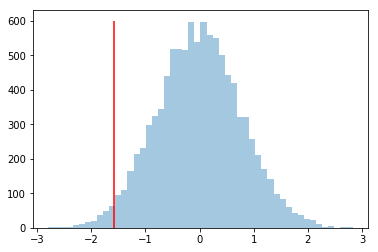

In [94]:
# plotting the distribution of mean differences
# using plt.vlines to plot a line at our observed difference 
_ = sns.distplot(rand_mean_diffs, norm_hist=False, kde=False)
_ = plt.vlines(observed_mean_diff, ymin=0,ymax=600, color='r')

In [99]:
# the plot should seem to indicate significance, but let's calculate a one-tailed p_value using rand_mean_diffs
p_value = sum(np.array(rand_mean_diffs) <= observed_mean_diff)/ len(rand_mean_diffs)
p_value

0.0192

In [114]:
# we can calculate the effect size of our observation
# this is the absolute value of the observed_mean_diff divided by the standard deviation of the combined_times
observed_effect_size = abs(observed_mean_diff/ np.std(combined_times))
observed_effect_size

0.09037820396090451

In [112]:
from statsmodels.stats.power import tt_ind_solve_power

In [115]:
# what is the power of our current experiment?
power = tt_ind_solve_power(effect_size = observed_effect_size,  # what we just calculated
                           nobs1 = n_A,         # the number of observations in A
                           alpha = 0.05,        # our alpha level
                           power = None,        # what we're interested in
                           ratio = 1            # the ratio of number of observations of A and B
                          )
power
# 50/50 bad as a coin toss

0.523949743916768

In [116]:
# how many observations for each of A and B would we need to get a power of .9
n_obs_A = tt_ind_solve_power(effect_size = observed_effect_size,  # what we just calculated
                           nobs1 = None,         # the number of observations in A
                           alpha = 0.05,        # our alpha level
                           power = 0.9,        # what we're interested in
                           ratio = 1            # the ratio of number of observations of A and B
                          )
n_obs_A

2573.717112042652

## Part 2: Data Cleaning and Regression

### Data Preparation and Exploration

This data is provided by World Bank Open Data https://data.worldbank.org/, processed as in Homework 1.

We will be performing regression with respect to GDP and classification with respect to Income Group.
To do that we will first need to do a little more data prep.

In [290]:
# read in the data
df_country = pd.read_csv('../data/country_electricity_by_region.csv')

# rename columns for ease of reference
columns = ['country_code','short_name','region','income_group','access_to_electricity','gdp','population_density',
           'population_total','unemployment','region_europe','region_latin_america_and_caribbean',
           'region_middle_east_and_north_africa','region_north_america','region_south_asia',
           'region_subsaharan_africa']

df_country.columns = columns
df_country.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217 entries, 0 to 216
Data columns (total 15 columns):
country_code                           217 non-null object
short_name                             217 non-null object
region                                 217 non-null object
income_group                           217 non-null object
access_to_electricity                  217 non-null float64
gdp                                    193 non-null float64
population_density                     215 non-null float64
population_total                       216 non-null float64
unemployment                           113 non-null float64
region_europe                          217 non-null int64
region_latin_america_and_caribbean     217 non-null int64
region_middle_east_and_north_africa    217 non-null int64
region_north_america                   217 non-null int64
region_south_asia                      217 non-null int64
region_subsaharan_africa               217 non-null int64
dtypes: flo

In [291]:
# create a dummy variable 'gdp_missing' to indicate where 'gdp' is null
df_country['gdp_missing'] = pd.get_dummies(df_country.gdp.isnull()).iloc[:,1]

In [292]:
# use groupby to find the number of missing gpd by income_level
# writing a lambda function to apply to the grouped data, counting the number of nulls per group
df_country.groupby('income_group').gdp.apply(lambda x: sum(x.isnull()))

income_group
High income            18
Low income              3
Lower middle income     1
Upper middle income     2
Name: gdp, dtype: int64

In [293]:
# fill in missing gdp values according to income_group mean
# inplace is not available here, so assigning back into the gdp column
df_country.gdp = df_country.groupby('income_group').gdp.apply(lambda x: x.fillna(np.mean(x)))

In [294]:
# assert that there are no longer any missing values in gdp
assert df_country.gdp.isnull().values.any() == False

In [295]:
# create 'populiation_density_missing' dummy variable
df_country['population_density_missing'] = pd.get_dummies(df_country.population_density.isnull()).iloc[:,1]

In [296]:
# fill in missing population_density with median, grouping by region
df_country.population_density =  df_country.groupby('region').population_density.apply(lambda x: x.fillna(np.nanmedian(x)))

In [297]:
df_country.groupby('region').population_density.median()

region
East Asia & Pacific           133.916835
Europe & Central Asia         101.083978
Latin America & Caribbean     103.506972
Middle East & North Africa     92.232223
North America                  34.825498
South Asia                    285.958588
Sub-Saharan Africa             60.169921
Name: population_density, dtype: float64

In [298]:
# create a normalized 'gdp_zscore' column
from scipy.stats import zscore
df_country['gdp_zscore'] = zscore(df_country.gdp)

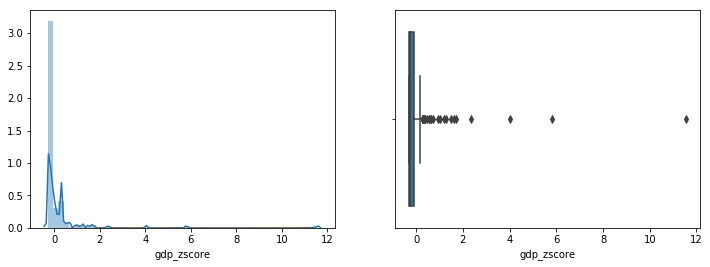

In [299]:
# using seaborn to create a distplot (with rugplot indicators) and a boxplot of gdp_zscores to visualize outliers
fig, ax = plt.subplots(1,2,figsize=(12,4))
_ = sns.distplot(df_country.gdp_zscore, ax=ax[0])
_ = sns.boxplot(df_country.gdp_zscore, ax=ax[1])

In [300]:
# print the top 10 country_code and gdp_zscore sorted by gdp_zscore
df_country[['country_code','gdp_zscore']].sort_values('gdp_zscore', ascending = False).iloc[:10]

,country_code,gdp_zscore
203,USA,11.552402
36,CHN,5.807531
98,JPN,4.035723
50,DEU,2.365951
64,FRA,1.717156
68,GBR,1.626685
26,BRA,1.479186
89,IND,1.264916
95,ITA,1.201040
32,CAN,1.007785


In [301]:
# setting a zscore cutoff to remove the top 4 outliers
gdp_zscore_cutoff = df_country.gdp_zscore.sort_values(ascending = False).iloc[3]

In [302]:
# a normalized 'population_density_zscore' column
df_country['population_density_zscore'] = zscore(df_country.population_density)

In [303]:
# print the top 10 country_code and population_density_zscore sorted by population_density_zscore
df_country[['country_code','population_density_zscore']].sort_values('population_density_zscore', ascending = False).iloc[:10]

,country_code,population_density_zscore
118,MAC,9.660487
121,MCO,9.474560
170,SGP,3.703655
82,HKG,3.287870
71,GIB,1.512029
19,BHR,0.662775
124,MDV,0.461115
129,MLT,0.460529
24,BMU,0.443888
17,BGD,0.404138


In [304]:
# setting a zscore cutoff to remove the top 5 outliers
population_density_zscore_cutoff = df_country.population_density_zscore.sort_values(ascending = False).iloc[4]

In [306]:
# drop outliers (considering both gdp_zscore and population_density_zscore)
df_country = df_country[(df_country.population_density_zscore < population_density_zscore_cutoff) & (df_country.gdp_zscore < gdp_zscore_cutoff)]
df_country.shape

(208, 19)

### Train a Regression Model

In [318]:
# create the training set of X with features (population_density, access_to_electricity) 
# and labels y (gdp)
X = df_country[['population_density', 'access_to_electricity']].values
y = df_country.gdp

In [319]:
# import and initialize a LinearRegression model using default parameters
from sklearn.linear_model import LinearRegression 
lr = LinearRegression()

In [320]:
# training the regressor on X and y
lr.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [321]:
# the learned intercept and coefficients
print('beta_0 = {:0.3f}'.format(regr.intercept_))
print('beta_1 = {:0.3f}'.format(regr.coef_[0]))
print('beta_2 = {:0.3f}'.format(regr.coef_[1]))

beta_0 = -124778701696.415
beta_1 = 93890100.767
beta_2 = 4352251616.858


In [328]:
# we can use this mask to easily index into our dataset
country_mask = (df_country.country_code == 'CAN').values

In [348]:
# how far off is our model's prediction for Canada's gdp (country_code CAN) from it's actual gdp?
lr.predict(df_country[country_mask].iloc[:,[4,6]])
# 1.779611e+12 is the actual value

array([-9.83776813e+10])

In [364]:
# creating a new training set X that, in addition to population_density and access_to_electricity,
# also includes the region_* dummies
X = df_country[['population_density','access_to_electricity','region_europe','region_latin_america_and_caribbean',
           'region_middle_east_and_north_africa','region_north_america','region_south_asia',
           'region_subsaharan_africa']].values

In [365]:
# instantiate a new model and train, with fit_intercept=False
lr = LinearRegression(fit_intercept=False).fit(X,y)

In [366]:
# did the prediction for CAN improve?
lr.predict(df_country[country_mask][['population_density','access_to_electricity','region_europe','region_latin_america_and_caribbean',
           'region_middle_east_and_north_africa','region_north_america','region_south_asia',
           'region_subsaharan_africa']])
# Yes, it is much closer to the original gdp value.

array([1.24960532e+12])